In [1]:
%run ./ipy_setup.py
%matplotlib inline

from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Graphics import GenomeDiagram
from reportlab.lib.units import cm
from sklearn import mixture
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy import stats
import itertools
import matplotlib.gridspec as gridspec

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}

#%run ../scripts/greedy_partitioner.py

In [3]:
#%run "~/2work/documents/scripts/greedy_partitioner.py"

In [5]:
#sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )
block_reader = HapCutReader('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds_fwd/test_hapcut_sig_denovo_merged_2.hapcut')

In [4]:
vcf_file = pd.read_csv('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds_fwd/hg002_fwd_all_positions_merged.tsv_sig.vcf', 
                      sep='\t', header=None)

In [5]:
siteslist = []
pbar = ProgressBar(61100)
for line in open("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_qv13_methyl_sig_sites-novariant-11mer.tsv", 'r'):
    pbar.animate()
    chrom, pos, mean1, mean2 = line.strip('\n').split(' ')
    pos, mean1, mean2 = int(pos), float(mean1), float(mean2)
    siteslist.append([chrom, pos, mean1, mean2])

[                  0%                  ]


In [23]:
blockpos = []
for i in block_reader.blocks:
    block = block_reader.loc(i)
    blockpos.append([i, block.chrom, block.start, block.end])

In [24]:
def getBlocks(in_start, in_end):
    return [b[0] for b in blockpos if ((b[2] < in_end) & (b[2] > in_start)) \
            | ((b[3] > in_start) & (b[3] < in_end)) | ((b[2] < in_start) & (b[3] > in_end))]

In [86]:
bam_fp = pysam.AlignmentFile("/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hg002.000000F.het_sites_truth_partition_snps_only.bam", "rb")
#out_fp = pysam.AlignmentFile("~/jason_new/hapcut_outputs/hg002_re_000000F/hg002_methyl_phased-from-trio-data_000000F.bam", 'wb')
#out_predict = open("/hpc/users/neffr01/jason_new/methyl_predict/hg002_methyl_denovo_vs_truth.tsv", "w")
predictions = []
pbar = ProgressBar(170000)
for bid, block in block_reader.blocks.iteritems():
    blockvars =  vcf_file.ix[[i-1 for i in block.variant_ids]]
    for read in bam_fp.fetch(region="000000F", start=block.start, end=block.end):
        pbar.animate()
        rstart, rend = read.pos, read.aend
        sigoverlap = blockvars[blockvars[1] >= rstart][blockvars[1] <= rend]
        if len(sigoverlap) == 0:
            continue
        refmap = get_refmap(read)
        ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
        #hap = int(read.get_tag('ZH').split(";")[0].split(",")[1])
        hap = read.get_tag('ZH')
        pv = read.get_tag('ZV')
        res = []
        for ix, row in sigoverlap.iterrows():
            refpos = row[1]
            basepos = get_position_in_read(read, refpos, refmap)
            if basepos==None: continue
            ipd_value = np.log(ipd_values[basepos])
            #motif = refseq[refpos-5-(rstart):refpos+6-rstart]
            #ref_3mer = motif[4:7]
            #read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
            #if ref_3mer != read_3mer: continue
            mean1 = float(row[7].split(";")[0].split("=")[1])
            mean2 = float(row[7].split(";")[1].split("=")[1])
            hapvariant = block.variant(ix+1)
            if hapvariant.hap1 == 1:
                tmp = mean1
                mean1 = mean2
                mean2 = tmp
            res.append([abs(mean1-ipd_value), abs(mean2-ipd_value)])
        if res != []:
            #print read.qname
            hap1_res = sum([i[0] for i in res])
            hap2_res = sum([i[1] for i in res])
            predict_hap = None
            if hap1_res > hap2_res:
                predict_hap = 2
            else:
                predict_hap = 1
            #print "Predicted:\t", predict_hap, "actual:\t", hap
            predictions.append([bid, rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen])
            #print >>sys.stdout, bid, rstart, rend, predict_hap, hap, len(res), pv, hap1_res, hap2_res, read.alen
            #out_predict.flush()
    break

[***               8%                  ]  13067 of 170000 complete Elapsed: 4.0 minutes	 Remaining: 48.4 minutes

KeyboardInterrupt: 

n= 10093


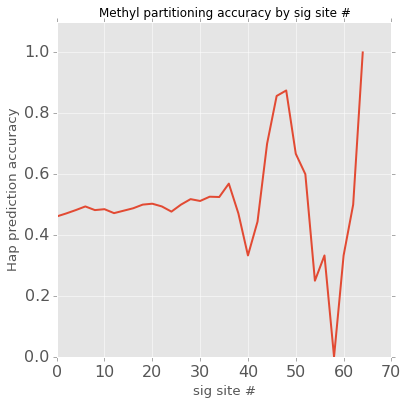

In [46]:
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for var in range(0,150,2):
    predcheck = [i for i in predictions if (i[5] > var) & (i[5] < var+8)]
    predcheck = [i for i in predcheck if (i[4] != 0)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if (i[3] == i[4]) else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n %", n/float(t)*100
plt.title("Methyl partitioning accuracy by sig site #")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0,1.1])
plt.xlabel("sig site #", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

In [57]:
type(predictions[-1][2])

int

n= 12927


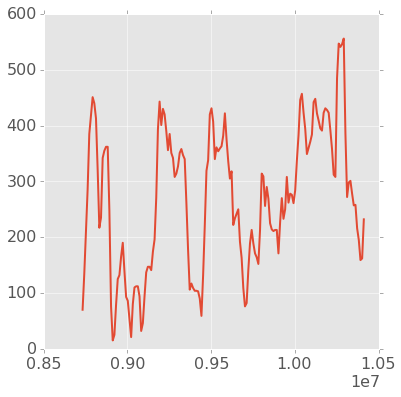

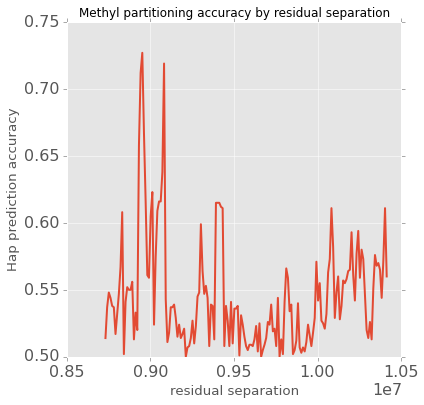

In [88]:
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for checkpos in range(8712241,10421250,10000):
    #print checkpos
    predcheck = [i for i in predictions if (i[2] <= checkpos) & (i[2] >= checkpos-50000)]
    predcheck = [i for i in predcheck if (i[4] != 0)]
    acc = round(np.mean([1 if (i[3] == i[4]) & (i[4] != 0) else 0 for i in predcheck]), 3)
    if acc < 0.5:
        acc = 1-acc
    n = len(predcheck)
    if n != 0:
        pltarr.append([checkpos, acc, n])
plt.plot([i[0] for i in pltarr], [i[2] for i in pltarr])
plt.show()
plt.title("Methyl partitioning accuracy by residual separation")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
#plt.ylim([0,1.1])
plt.xlabel("residual separation", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()

In [76]:
pltarr

[[10392241, 0.407, 91]]

n= 10093


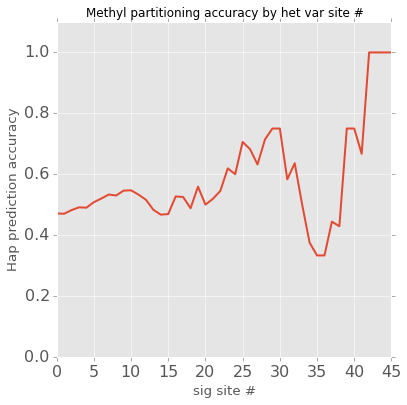

In [45]:
rcParams['figure.figsize'] = (6, 6)
rcParams['axes.titlesize'] = 12
pltarr = []
t = len(predictions)
print "n=", len(predictions)
for var in range(0,50,1):
    predcheck = [i for i in predictions if (i[6] > var) & (i[6] < var+5)]
    predcheck = [i for i in predcheck if (i[4] != 0)]
    if len(predcheck) == 0:
        break
    acc = round(np.mean([1 if (i[3] == i[4]) & (i[4] != 0) else 0 for i in predcheck]), 3)
    n = len(predcheck)
    pltarr.append([var, acc, n])
    #print "partition variants >=", var, "prediction acc:", acc , "n %", n/float(t)*100
plt.title("Methyl partitioning accuracy by het var site #")
plt.plot([i[0] for i in pltarr], [i[1] for i in pltarr])
plt.ylim([0,1.1])
plt.xlabel("sig site #", fontsize='small')
plt.ylabel("Hap prediction accuracy", fontsize='small')
plt.show()